### Project: High-Throughput System for Batch Analysis of Retinal Scans

Here is a comprehensive Google Colab notebook structure designed to address your project requirements. This notebook will guide you through training a deep learning model to classify retinal images and then using that model to perform batch analysis on a directory of new images.

The "Ocular Disease Recognition" (ODIR) dataset from Kaggle is a suitable choice for this task. It contains 5,000 patient cases with fundus photographs of both left and right eyes, annotated with eight different labels, including Normal, Diabetes, and Glaucoma.

**Note on the ODIR Dataset:** This dataset presents some challenges. It is highly imbalanced, with a large number of "Normal" images compared to specific diseases. Additionally, the primary labels correspond to the patient, not necessarily individual eye images, which can lead to complexities in training. For the purpose of this notebook, we will focus on a simplified three-class problem: Normal, Diabetic Retinopathy, and Glaucoma.

---

### Google Colab Notebook

#### 1. Setup

This section installs necessary libraries and imports the required modules for the project.

In [1]:
!pip install tensorflow pandas numpy scikit-learn matplotlib seaborn opendatasets

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import opendatasets as od

#### 2. Data Ingestion & Preprocessing

Here, we download the "Ocular Disease Recognition" dataset from Kaggle and preprocess it for our model.

In [2]:
# Download the dataset from Kaggle
od.download("https://www.kaggle.com/andrewmvd/ocular-disease-recognition-odir5k")

# Path to the dataset
data_dir = './ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images'

# Load the labels
labels_path = './ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/data.xlsx' # Corrected path
labels_df = pd.read_excel(labels_path)

# Define the classes based on dataset documentation/common pathologies
# N, D, G, C, A, H, M, O
classes = [
    'Normal',
    'Diabetes',
    'Glaucoma',
    'Cataract',
    'Age related Macular Degeneration',
    'Hypertension',
    'Pathological Myopia',
    'Other diseases/abnormalities'
]

# Function to parse keywords and create one-hot encoded labels
def get_labels(keywords):
    labels = {cls: 0 for cls in classes}
    if 'normal' in keywords:
        labels['Normal'] = 1
    if 'diabetic retinopathy' in keywords:
        labels['Diabetes'] = 1
    if 'glaucoma' in keywords:
        labels['Glaucoma'] = 1
    if 'cataract' in keywords:
        labels['Cataract'] = 1
    if 'age-related macular degeneration' in keywords:
        labels['Age related Macular Degeneration'] = 1
    if 'hypertensive retinopathy' in keywords:
        labels['Hypertension'] = 1
    if 'pathological myopia' in keywords:
        labels['Pathological Myopia'] = 1
    if 'other' in keywords: # Simplified check for 'other'
         labels['Other diseases/abnormalities'] = 1
    return list(labels.values())

# Create a list of image records with multi-label format
image_records = []
for _, row in labels_df.iterrows():
    left_labels = get_labels(row['Left-Diagnostic Keywords'].lower())
    right_labels = get_labels(row['Right-Diagnostic Keywords'].lower())
    image_records.append({'filename': row['Left-Fundus'], **dict(zip(classes, left_labels))})
    image_records.append({'filename': row['Right-Fundus'], **dict(zip(classes, right_labels))})

# Create the final DataFrame
image_df = pd.DataFrame(image_records)

# Data augmentation and splitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, # 80% training, 20% validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
    dataframe=image_df,
    directory=data_dir,
    x_col="filename",
    y_col=classes,
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw", # Use "raw" for multi-label
    target_size=(224, 224))

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=image_df,
    directory=data_dir,
    x_col="filename",
    y_col=classes,
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw", # Use "raw" for multi-label
    target_size=(224, 224))

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yeshankavindu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k


100%|██████████| 1.62G/1.62G [00:11<00:00, 146MB/s]



Found 5600 validated image filenames.
Found 1400 validated image filenames.


#### 3. Model Architecture

We will use a pre-trained ResNet50 model and add a custom classification head.

In [3]:
# --- Replacement for Cell 3: Model Architecture ---

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# The output layer now has 8 neurons (one for each class) and uses sigmoid activation
predictions = Dense(len(classes), activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#### 4. Model Training

This section compiles and trains the model.

In [4]:
# Use binary_crossentropy for multi-label classification
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)])

# Callbacks
checkpoint = ModelCheckpoint("retinal_model_multilabel.h5", save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(
    train_generator,
    epochs=1,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6217 - auc: 0.4404 - loss: 0.3243

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 1327s 8s/step - accuracy: 0.6224 - auc: 0.4404 - loss: 0.3239 - val_accuracy: 0.8207 - val_auc: 0.4465 - val_loss: 0.1989 - learning_rate: 1.0000e-04


#### 5. Performance Evaluation

Evaluate the model's performance on the validation set.

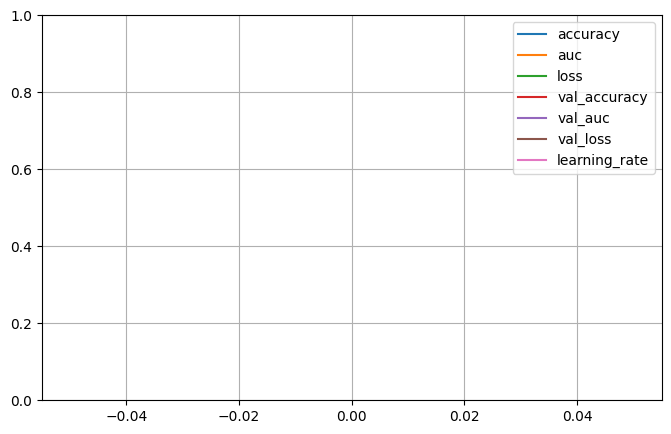

Generating predictions for validation set...
44/44 ━━━━━━━━━━━━━━━━━━━━ 277s 6s/step
Confusion Matrix (per class)

Confusion Matrix for Normal


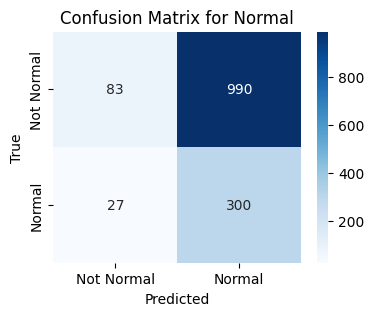


Confusion Matrix for Diabetes


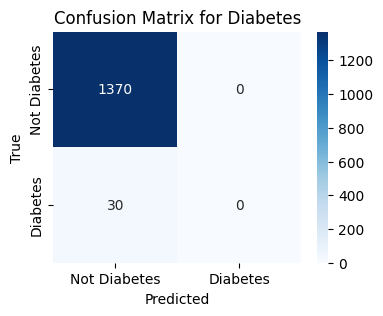


Confusion Matrix for Glaucoma


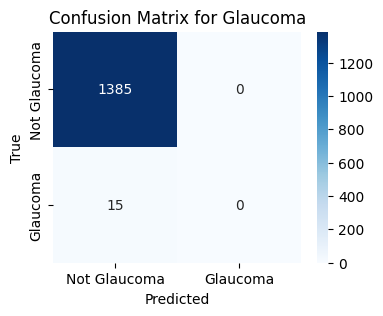


Confusion Matrix for Cataract


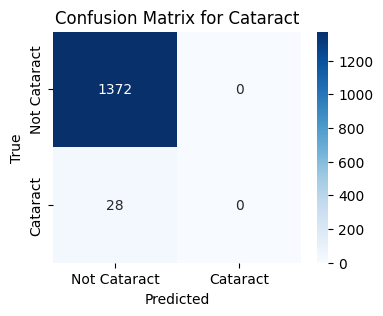


Confusion Matrix for Age related Macular Degeneration


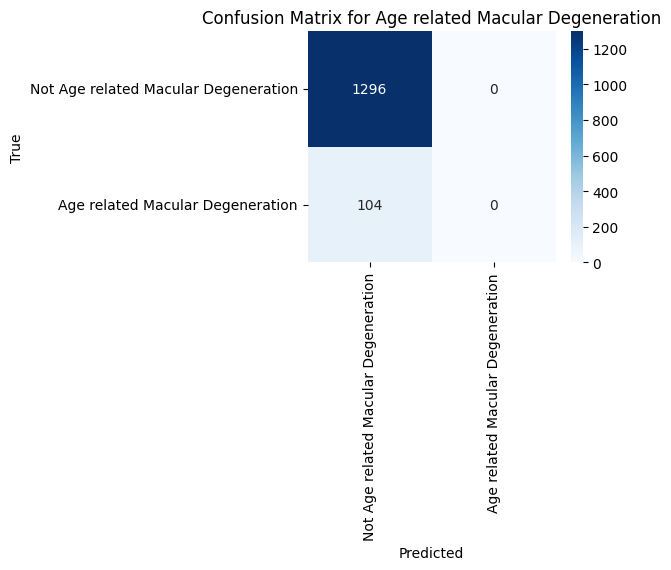


Confusion Matrix for Hypertension


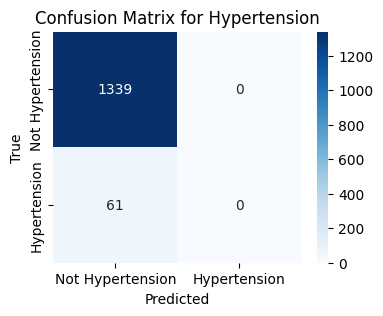


Confusion Matrix for Pathological Myopia


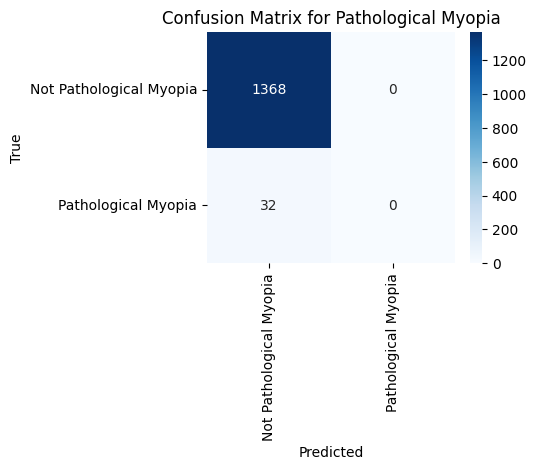


Confusion Matrix for Other diseases/abnormalities


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


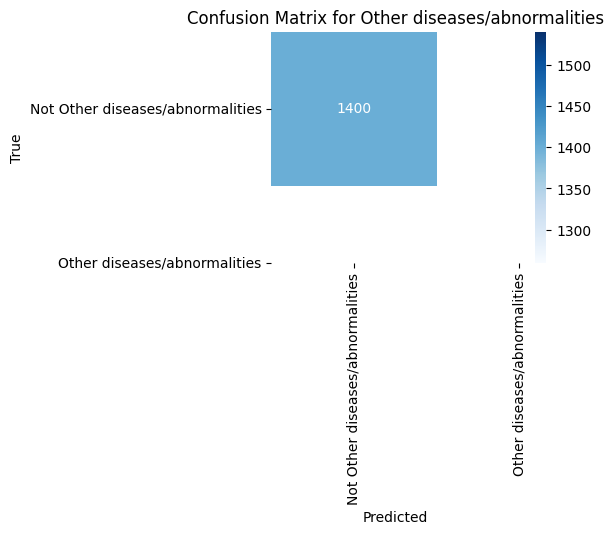


Classification Report


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                  precision    recall  f1-score   support

                          Normal       0.23      0.92      0.37       327
                        Diabetes       0.00      0.00      0.00        30
                        Glaucoma       0.00      0.00      0.00        15
                        Cataract       0.00      0.00      0.00        28
Age related Macular Degeneration       0.00      0.00      0.00       104
                    Hypertension       0.00      0.00      0.00        61
             Pathological Myopia       0.00      0.00      0.00        32
    Other diseases/abnormalities       0.00      0.00      0.00         0

                       micro avg       0.23      0.50      0.32       597
                       macro avg       0.03      0.11      0.05       597
                    weighted avg       0.13      0.50      0.20       597
                     samples avg       0.21      0.21      0.21       597


ROC AUC Score (macro average): nan

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

In [7]:
# Plot training history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Confusion Matrix and Classification Report for multi-label classification

# Get the true labels for the validation set
# We need to iterate through the validation generator to get the true labels
y_true = []
filenames = validation_generator.filenames
# Assuming image_df contains the original labels and filenames
# Filter image_df to get only validation images and their corresponding labels
validation_df = image_df[image_df['filename'].isin(filenames)]
# Ensure the order of labels matches the order of predictions
validation_df = validation_df.set_index('filename').loc[filenames].reset_index()

y_true = validation_df[classes].values


print('Generating predictions for validation set...')
# Get the model's predictions for the validation set
Y_pred = model.predict(validation_generator)

# For multi-label, we typically threshold the probabilities (e.g., at 0.5)
# to get binary predictions for each class.
y_pred_binary = (Y_pred > 0.5).astype(int)

print('Confusion Matrix (per class)')
# Calculate and plot confusion matrix for each class
for i, class_name in enumerate(classes):
    print(f'\nConfusion Matrix for {class_name}')
    cm = confusion_matrix(y_true[:, i], y_pred_binary[:, i])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Not {class_name}', class_name], yticklabels=[f'Not {class_name}', class_name])
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


print('\nClassification Report')
# Generate classification report for multi-label
# The classification report can directly handle multi-label output
print(classification_report(y_true, y_pred_binary, target_names=classes))

# Calculate ROC AUC score for multi-label
# roc_auc_score can also handle multi-label by averaging
try:
    roc_auc = roc_auc_score(y_true, Y_pred, average='macro')
    print(f'\nROC AUC Score (macro average): {roc_auc:.4f}')
except ValueError as e:
    print(f"\nCould not calculate ROC AUC: {e}")
    print("This can happen if a class has only one sample.")

#### 6. Batch Processing & Inference

This function takes a directory of new images and generates predictions.

In [8]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

def batch_predict(image_dir, model_path, class_labels):
    model = load_model(model_path)
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    results = []

    for filename in image_files:
        img_path = os.path.join(image_dir, filename)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        predictions = model.predict(img_array)[0]
        result_dict = {'filename': filename}
        # Create a dictionary mapping class label to its predicted probability
        for label, prob in zip(class_labels, predictions):
            result_dict[f'{label}_prob'] = prob
        results.append(result_dict)

    return pd.DataFrame(results)

# Example usage:
# !mkdir -p new_images
# # (add some images to this directory)
# batch_results = batch_predict('new_images', 'retinal_model_multilabel.h5', classes)
# print(batch_results.head())

#### 7. Results Aggregation & Reporting

This final section provides summary statistics and visualizations of the batch predictions.

In [9]:
def analyze_batch_results_multilabel(df, class_labels, threshold=0.5):
    prob_cols = [f'{label}_prob' for label in class_labels]

    # Identify all predicted labels for each image based on the threshold
    predicted_labels = df[prob_cols].gt(threshold)
    predicted_labels.columns = class_labels

    # Concatenate results for analysis
    analysis_df = pd.concat([df[['filename']], predicted_labels], axis=1)

    # Generate Summary Statistics
    summary_stats = analysis_df[class_labels].sum()
    print("Summary Statistics (Total Counts):")
    print(summary_stats)
    print("\n")

    # Create Visualizations
    summary_stats.plot(kind='bar', title='Distribution of Predicted Conditions (Batch Summary)')
    plt.ylabel('Total Detections')
    plt.show()

    # Prioritize High-Risk Cases
    # A case is high-risk if any pathology (non-Normal) is detected
    pathology_labels = [label for label in class_labels if label != 'Normal']
    analysis_df['is_high_risk'] = analysis_df[pathology_labels].any(axis=1)

    high_risk_df = analysis_df[analysis_df['is_high_risk']].copy()

    # Find the highest pathology probability for sorting
    pathology_prob_cols = [f'{label}_prob' for label in pathology_labels]
    high_risk_df['max_risk_prob'] = df.loc[high_risk_df.index, pathology_prob_cols].max(axis=1)

    # Get the list of predicted diseases for high-risk cases
    def get_detected_diseases(row):
        return [label for label in pathology_labels if row[label]]
    high_risk_df['detected_diseases'] = high_risk_df.apply(get_detected_diseases, axis=1)

    high_risk_sorted = high_risk_df.sort_values(by='max_risk_prob', ascending=False)

    print("High-Priority Cases (Any Pathology Detected):")
    print(high_risk_sorted[['filename', 'detected_diseases', 'max_risk_prob']])

# Example usage with the results from the previous step:
# analyze_batch_results_multilabel(batch_results, classes)